# Weather predictions for: Gdansk, Szczecin, Rzeszow, Warszawa and Krakow
### Each csv file with city_2022 is ready for testing

In [2]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import numpy as np
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, model_from_json
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Preparation

In [59]:
# GLOBAL 
# relh	 skph 	temp


# mean and standard for data normalization and denormalization
mean_and_std = pd.read_csv("lstm_models/mean_and_std")
training_mean = mean_and_std['mean']
training_std = mean_and_std['std']

# lstm and xgboost biases
lstm_bias_df = pd.read_csv("lstm_models/biases_lstm")
lstm_bias_df.drop('Unnamed: 0',axis='columns', inplace=True)
xgb_bias_df = pd.read_csv("xgb_models/biases_xgboost")
xgb_bias_df.drop('Unnamed: 0',axis='columns', inplace=True)


lstm_bias = []
xgb_bias = []

for i in range(3):
    lstm_bias.append(lstm_bias_df.iloc[i].values)
    xgb_bias.append(xgb_bias_df.iloc[i].values)

In [60]:
lstm_bias

[array([ 0.41846198, -0.04263697, -0.21242941]),
 array([ 1.08576316, -0.3452743 , -0.57540885]),
 array([ 1.31105306, -0.57163975, -0.22380084])]

In [51]:
lstm_bias_df

,Unnamed: 0,humid,wind,temp
0,0,0.418462,-0.042637,-0.212429
1,1,1.085763,-0.345274,-0.575409
2,2,1.311053,-0.571640,-0.223801


In [19]:
# models load
model_lstm = []
model_lstm.append(pickle.load(open("lstm_models/lstm12steps30min_2.pkl", "rb", -1)))
model_lstm.append(pickle.load(open("lstm_models/lstm12steps30min_4.pkl", "rb", -1)))
model_lstm.append(pickle.load(open("lstm_models/lstm12steps30min_6.pkl", "rb", -1)))

model_xgb = []
model_xgb.append(pickle.load(open("xgb_models/xgb1.pkl", "rb", -1)))
model_xgb.append(pickle.load(open("xgb_models/xgb2.pkl", "rb", -1)))
model_xgb.append(pickle.load(open("xgb_models/xgb3.pkl", "rb", -1)))

# Global functions

In [36]:
# for LSTM
def norm(X, y, index, training_mean, training_std):
    X[:, :, index] = (X[:, :, index] - training_mean) / training_std
    y[:, index] = (y[:, index] - training_mean) / training_std


def transform_data(df_input, window_size = 12, timestamps_count = 0):
    df_input = df_input.to_numpy()
    features_len = df_input.shape[1]
    data_count = len(df_input)
    X = []
    y = []
    # Explanatory X and Response y variables 
    for i in range(data_count-window_size - timestamps_count):
        row = [r for r in df_input[i:i+window_size]]
        X.append(row)
        label = [df_input[i+window_size + timestamps_count]]
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    resh0 = y.shape[0]
    resh1 = y.shape[2]
    y = y.reshape(resh0, resh1)
    
    # data normalization
    for i in range(features_len):
        norm(X, y, i, training_mean[i], training_std[i])

    return  X, y

In [16]:
# for LSTM
def denormalization(y, training_mean, training_std):
  y = (y*training_std) + training_mean
  return y

# Calculations for Lodz

In [6]:
# Read the CSV file for Lodz
all_data = pd.read_csv("data_distance_from_Lodz/Lodz_2022.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)

In [82]:
# data for lstm model
all_data_lstm = all_data[["relh", "skph", "temp"]]

# data for xGBoost model
all_data_x = all_data.copy()
all_data_x.rename(columns ={'temp':'tmpc', 'skph':'sped'}, inplace=True)
all_data_x['hour'] = pd.to_datetime(all_data['time']).dt.hour
all_data_x.drop('time',axis='columns', inplace=True)
all_data_x.insert(loc=0, column="lat", value=51) # latitude for Lodz = 51
all_data_x.insert(loc=0, column="lon", value=19) # longtitude for Lodz = 19

all_data_x = all_data_x[all_data_x['minutes'] == 0]
all_data_x.drop('minutes',axis='columns', inplace=True)

In [71]:
MAE_humid_lstm = []
MAE_wind_lstm = []
MAE_temp_lstm = []

for hour in range(3): # cause predicitons for next 3 hours
    X, y = transform_data(all_data_lstm,12,hour)
    # # make predictions
    predictions = model_lstm[hour].predict(X)

    pred = []
    actual =[]
    
    features_len = y.shape[1]
    for i in range(features_len):
        denormalized = denormalization(predictions[:,i], training_mean[i], training_std[i]) - lstm_bias[hour][i]
        pred.append(denormalized)
        actual.append(denormalization(y[:,i], training_mean[i], training_std[i]))
    MAE_humid_lstm.append(mean_absolute_error(actual[0], pred[0]))
    MAE_wind_lstm.append(mean_absolute_error(actual[1], pred[1]))
    MAE_temp_lstm.append(mean_absolute_error(actual[2], pred[2]))


546/546 [==============================] - 2s 3ms/step


In [91]:
MAE_humid_xgb = []
MAE_wind_xgb = []
MAE_temp_xgb = []

for hour in range(1,4): # cause predicitons for next 3 hours
    # # make predictions
    X = all_data_x[:-hour]
    y = all_data_x[hour:]
    y_pred_xgb = model_xgb[hour-1].predict(X)
    y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=[ "lon", "lat",  "tmpc",  "relh" ,"sped" ,"day","month", "year", "hour"])

    MAE_humid_xgb.append(mean_absolute_error(y_pred_xgb[["relh"]] - xgb_bias[hour-1][0],y[["relh"]]))
    MAE_wind_xgb.append(mean_absolute_error(y_pred_xgb[["sped"]]- xgb_bias[hour-1][1],y[["sped"]]))
    MAE_temp_xgb.append(mean_absolute_error(y_pred_xgb[["tmpc"]]- xgb_bias[hour-1][2],y[["tmpc"]]))

Text(0.5, 1.0, 'temperature')

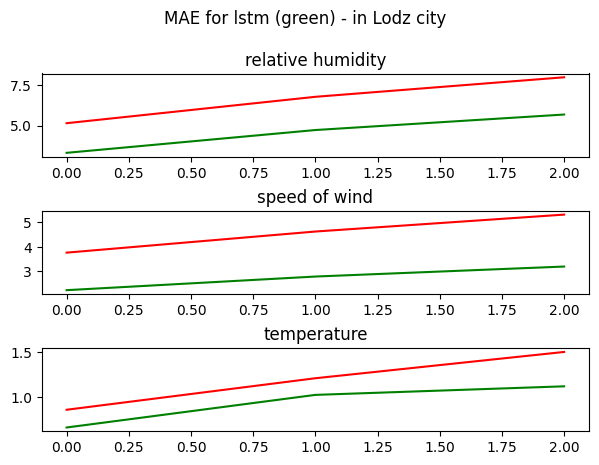

In [126]:
fig, axs = plt.subplots(3)
fig.suptitle('MAE for lstm (green) - in Lodz city')
fig.tight_layout(pad=1.8)
axs[0].plot(MAE_humid_xgb, 'r')
axs[0].plot(MAE_humid_lstm,'g')
axs[0].set_title('relative humidity')

axs[1].plot(MAE_wind_xgb,'r')
axs[1].plot(MAE_wind_lstm,'g')
axs[1].set_title('speed of wind')

axs[2].plot(MAE_temp_xgb,'r')
axs[2].plot(MAE_temp_lstm,'g')
axs[2].set_title('temperature')

In [105]:
res = {}
long_lat = {
    "Gdansk_2022_lon":18.64,"Gdansk_2022_lat":54.35, "Krakow_2022_lon":19.9450,"Krakow_2022_lat":50.0647, "Rzeszow_2022_lon": 22, "Rzeszow_2022_lat":50.04  ,
      "Szczecin_2022_lon":14.55, "Szczecin_2022_lat":53.42, "Warszawa_2022_lon":21.01, "Warszawa_2022_lat":52.22
}

MAE_lstm_all = {}
MAE_xgb_all = {}

all_cities = ["Gdansk_2022", "Krakow_2022", "Rzeszow_2022", "Szczecin_2022", "Warszawa_2022"]

for city in all_cities:
    print(city)
    fileName = "data_distance_from_Lodz/" + city + ".csv"
    all_data = pd.read_csv(fileName)
    all_data.drop('Unnamed: 0',axis='columns', inplace=True)

    # data for lstm model #####################
    all_data_lstm = all_data[["relh", "skph", "temp"]]

    # data for xGBoost model #####################
    all_data_x = all_data.copy()
    all_data_x.rename(columns ={'temp':'tmpc', 'skph':'sped'}, inplace=True)
    all_data_x['hour'] = pd.to_datetime(all_data['time']).dt.hour
    all_data_x.drop('time',axis='columns', inplace=True)

    # different lon and lat
    lon = long_lat[city+"_lon"]
    lat = long_lat[city+"_lat"]
    all_data_x.insert(loc=0, column="lat", value=lat) 
    all_data_x.insert(loc=0, column="lon", value=lon) 

    all_data_x = all_data_x[all_data_x['minutes'] == 0]
    all_data_x.drop('minutes',axis='columns', inplace=True)

    ######################### LSTM ###############################

    MAE_humid_lstm_temp = []
    MAE_wind_lstm_temp = []
    MAE_temp_lstm_temp = []

    for hour in range(3): # cause predicitons for next 3 hours
        X, y = transform_data(all_data_lstm,12,hour)
        # # make predictions
        predictions = model_lstm[hour].predict(X)

        pred = []
        actual =[]
        
        features_len = y.shape[1]
        for i in range(features_len):
            denormalized = denormalization(predictions[:,i], training_mean[i], training_std[i]) - lstm_bias[hour][i]
            pred.append(denormalized)
            actual.append(denormalization(y[:,i], training_mean[i], training_std[i]))

        MAE_humid_lstm_temp.append(mean_absolute_error(actual[0], pred[0]))
        MAE_wind_lstm_temp.append(mean_absolute_error(actual[1], pred[1]))
        MAE_temp_lstm_temp.append(mean_absolute_error(actual[2], pred[2]))
    # save data for each place
    MAE_lstm_all[city] = [MAE_humid_lstm_temp, MAE_wind_lstm_temp, MAE_temp_lstm_temp]

    ########################### XGB #############################
    MAE_humid_xgb_temp = []
    MAE_wind_xgb_temp = []
    MAE_temp_xgb_temp = []

    for hour in range(1,4): # cause predicitons for next 3 hours
        # # make predictions
        X = all_data_x[:-hour]
        y = all_data_x[hour:]
        y_pred_xgb = model_xgb[hour-1].predict(X)
        y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=[ "lon", "lat",  "tmpc",  "relh" ,"sped" ,"day","month", "year", "hour"])

        MAE_humid_xgb_temp.append(mean_absolute_error(y_pred_xgb[["relh"]] - xgb_bias[hour-1][0],y[["relh"]]))
        MAE_wind_xgb_temp.append(mean_absolute_error(y_pred_xgb[["sped"]]- xgb_bias[hour-1][1],y[["sped"]]))
        MAE_temp_xgb_temp.append(mean_absolute_error(y_pred_xgb[["tmpc"]]- xgb_bias[hour-1][2],y[["tmpc"]]))

    # save data for each place
    MAE_xgb_all[city] = [MAE_humid_xgb_temp, MAE_wind_xgb_temp, MAE_temp_xgb_temp]     


Gdansk_2022
1055/1055 [==============================] - 3s 3ms/step
Krakow_2022
1055/1055 [==============================] - 3s 3ms/step
Rzeszow_2022
1055/1055 [==============================] - 3s 3ms/step
Szczecin_2022
1055/1055 [==============================] - 3s 3ms/step
Warszawa_2022
1055/1055 [==============================] - 3s 3ms/step


In [106]:
# humid wind temp
MAE_lstm_all

{'Gdansk_2022': [[3.277481722313585, 4.507635123188311, 5.494592412495533],
  [2.382585069594048, 2.996376689064575, 3.4982918663219853],
  [0.58819471913467, 0.9058278913586921, 0.9900419645105457]],
 'Krakow_2022': [[3.3927891241548553, 4.69458044674045, 5.560623587398029],
  [2.29259675614041, 2.91802792850915, 3.3122943969294982],
  [0.6742509617594628, 1.010478413436609, 1.1067182671643785]],
 'Rzeszow_2022': [[3.2016672555395824, 4.434022225874267, 5.360295962746626],
  [2.4636989919227488, 3.0496418495139794, 3.423372954816118],
  [0.6278319121441742, 0.9608401664590601, 1.0281385022726521]],
 'Szczecin_2022': [[3.330581078974971, 4.692901572534613, 5.664994016228884],
  [2.1832567164619445, 2.7346119556777686, 3.127050235919708],
  [0.6531554308078907, 0.9872267543695574, 1.0950944264561444]],
 'Warszawa_2022': [[3.271125984067571, 4.583171689498408, 5.591883894318757],
  [2.1685297923583393, 2.702719493705048, 3.087621085211125],
  [0.6606253896581424, 1.02426952002317, 1.0804

In [108]:
# humid wind temp
MAE_xgb_all

{'Gdansk_2022': [[4.9536671778117, 6.486422843198771, 7.6541131594327645],
  [3.740568087932315, 4.591724997494435, 5.104829887809907],
  [0.7930809786308047, 1.1219913013875644, 1.4036999260239897]],
 'Krakow_2022': [[5.07459619545592, 6.622743906166742, 7.627145312580081],
  [3.8499007422498823, 4.750186856353632, 5.363036282581566],
  [0.8755026790848476, 1.2330109842321513, 1.5135768869243666]],
 'Rzeszow_2022': [[4.871978152351225, 6.3861124127787985, 7.449991681899183],
  [3.8436208196790815, 4.624864570967105, 5.068657857087279],
  [0.8109647050262507, 1.157472965362311, 1.4364143640187774]],
 'Szczecin_2022': [[4.973014793949702, 6.583741595501837, 7.5694357938834855],
  [3.49674617170249, 4.243924325511497, 4.700901724363941],
  [0.8177984070002599, 1.1452567162150447, 1.3871010646909174]],
 'Warszawa_2022': [[4.931726963411576, 6.477689282263446, 7.5077103789449655],
  [3.495888072008021, 4.237603768043647, 4.706231757250501],
  [0.8189994499431614, 1.14122390988125, 1.404091

In [110]:
all_cities = ["Gdansk_2022", "Krakow_2022", "Rzeszow_2022", "Szczecin_2022", "Warszawa_2022"]

# Results!

In [114]:
# humid

data_h = pd.DataFrame()
data_h['Lodz_2022_lstm'] = MAE_humid_lstm
data_h['Lodz_2022_xgb'] = MAE_humid_xgb

for city in all_cities:
    name_lstm = city + "_lstm"
    data_h[name_lstm] = MAE_lstm_all[city][0]

    name_xgb = city + "_xgb"
    data_h[name_xgb] = MAE_xgb_all[city][0]

data_h

,Lodz_2022_lstm,Lodz_2022_xgb,Gdansk_2022_lstm,Gdansk_2022_xgb,Krakow_2022_lstm,Krakow_2022_xgb,Rzeszow_2022_lstm,Rzeszow_2022_xgb,Szczecin_2022_lstm,Szczecin_2022_xgb,Warszawa_2022_lstm,Warszawa_2022_xgb
0,3.307310,5.146359,3.277482,4.953667,3.392789,5.074596,3.201667,4.871978,3.330581,4.973015,3.271126,4.931727
1,4.722108,6.784207,4.507635,6.486423,4.694580,6.622744,4.434022,6.386112,4.692902,6.583742,4.583172,6.477689
2,5.684518,7.996344,5.494592,7.654113,5.560624,7.627145,5.360296,7.449992,5.664994,7.569436,5.591884,7.507710


In [115]:
# humid lstm only

data_h_lstm = pd.DataFrame()
data_h_lstm['Lodz_2022_lstm'] = MAE_humid_lstm

for city in all_cities:
    name_lstm = city + "_lstm"
    data_h_lstm[name_lstm] = MAE_lstm_all[city][0]

data_h_lstm

,Lodz_2022_lstm,Gdansk_2022_lstm,Krakow_2022_lstm,Rzeszow_2022_lstm,Szczecin_2022_lstm,Warszawa_2022_lstm
0,3.307310,3.277482,3.392789,3.201667,3.330581,3.271126
1,4.722108,4.507635,4.694580,4.434022,4.692902,4.583172
2,5.684518,5.494592,5.560624,5.360296,5.664994,5.591884


In [117]:
# wind

data_w = pd.DataFrame()
data_w['Lodz_2022_lstm'] = MAE_wind_lstm
data_w['Lodz_2022_xgb'] = MAE_wind_xgb

for city in all_cities:
    name_lstm = city + "_lstm"
    data_w[name_lstm] = MAE_lstm_all[city][1]

    name_xgb = city + "_xgb"
    data_w[name_xgb] = MAE_xgb_all[city][1]

data_w

,Lodz_2022_lstm,Lodz_2022_xgb,Gdansk_2022_lstm,Gdansk_2022_xgb,Krakow_2022_lstm,Krakow_2022_xgb,Rzeszow_2022_lstm,Rzeszow_2022_xgb,Szczecin_2022_lstm,Szczecin_2022_xgb,Warszawa_2022_lstm,Warszawa_2022_xgb
0,2.245862,3.758981,2.382585,3.740568,2.292597,3.849901,2.463699,3.843621,2.183257,3.496746,2.168530,3.495888
1,2.794971,4.610370,2.996377,4.591725,2.918028,4.750187,3.049642,4.624865,2.734612,4.243924,2.702719,4.237604
2,3.198332,5.292672,3.498292,5.104830,3.312294,5.363036,3.423373,5.068658,3.127050,4.700902,3.087621,4.706232


In [118]:
# wind lstm only

data_w_lstm = pd.DataFrame()
data_w_lstm['Lodz_2022_lstm'] = MAE_wind_lstm

for city in all_cities:
    name_lstm = city + "_lstm"
    data_w_lstm[name_lstm] = MAE_lstm_all[city][1]

data_w_lstm

,Lodz_2022_lstm,Gdansk_2022_lstm,Krakow_2022_lstm,Rzeszow_2022_lstm,Szczecin_2022_lstm,Warszawa_2022_lstm
0,2.245862,2.382585,2.292597,2.463699,2.183257,2.168530
1,2.794971,2.996377,2.918028,3.049642,2.734612,2.702719
2,3.198332,3.498292,3.312294,3.423373,3.127050,3.087621


In [119]:
# temp
data_t = pd.DataFrame()
data_t['Lodz_2022_lstm'] = MAE_temp_lstm
data_t['Lodz_2022_xgb'] = MAE_temp_xgb

for city in all_cities:
    name_lstm = city + "_lstm"
    data_t[name_lstm] = MAE_lstm_all[city][2]

    name_xgb = city + "_xgb"
    data_t[name_xgb] = MAE_xgb_all[city][2]

data_t

,Lodz_2022_lstm,Lodz_2022_xgb,Gdansk_2022_lstm,Gdansk_2022_xgb,Krakow_2022_lstm,Krakow_2022_xgb,Rzeszow_2022_lstm,Rzeszow_2022_xgb,Szczecin_2022_lstm,Szczecin_2022_xgb,Warszawa_2022_lstm,Warszawa_2022_xgb
0,0.672279,0.865854,0.588195,0.793081,0.674251,0.875503,0.627832,0.810965,0.653155,0.817798,0.660625,0.818999
1,1.028202,1.209801,0.905828,1.121991,1.010478,1.233011,0.960840,1.157473,0.987227,1.145257,1.024270,1.141224
2,1.121718,1.496836,0.990042,1.403700,1.106718,1.513577,1.028139,1.436414,1.095094,1.387101,1.080444,1.404091


In [121]:
# temp lstm only
data_t_lstm = pd.DataFrame()
data_t_lstm['Lodz_2022_lstm'] = MAE_temp_lstm

for city in all_cities:
    name_lstm = city + "_lstm"
    data_t_lstm[name_lstm] = MAE_lstm_all[city][2]

data_t_lstm

,Lodz_2022_lstm,Gdansk_2022_lstm,Krakow_2022_lstm,Rzeszow_2022_lstm,Szczecin_2022_lstm,Warszawa_2022_lstm
0,0.672279,0.588195,0.674251,0.627832,0.653155,0.660625
1,1.028202,0.905828,1.010478,0.960840,0.987227,1.024270
2,1.121718,0.990042,1.106718,1.028139,1.095094,1.080444
